# Beer Image Processing
#### Using cv2 and tensorflow (DNN and LSTM) 

## IMPORTING

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## PREPROCESSING

In [2]:
def get_beer_color(image):
    # Resize the image
    cropped_image = image[94:118, 114:138] # 24 x 24
    
    # Calculate the average color (BGR format)
    avg_color = cv2.mean(cropped_image)[:3]
    
    avg_color_rgb = avg_color[::-1]

    return avg_color_rgb

In [3]:
def get_sediment_image(image):
    # Resize the image
    image = image[212:256, 64:192] # 128 x 44
    
    # Convert the image depth to CV_32F if necessary
    if image.dtype != np.float32:
        image = image.astype(np.float32)
    
    return image

In [4]:
def get_foam_image(image):
    # Resize the image
    image = image[14:94, 92:108] # 16 x 70
    
    # Convert the image depth to CV_32F if necessary
    if image.dtype != np.float32:
        image = image.astype(np.float32)
        
    return image

In [5]:
def to_grayscale(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

def increase_brightness_contrast(image, alpha=1.0, beta=0):
    # Adjust the brightness and contrast of the image
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted_image

In [6]:
def normalize(image):
    # normalization for visualisation
    image_data_type = image.dtype

    if image_data_type == np.float32 or image_data_type == np.float64:
        # Normalize the float image to the range [0, 1]
        normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    else:
        # Convert the image to float and normalize it to the range [0, 1]
        normalized_image = image.astype(np.float32) / 255.0

    return normalized_image
    

In [7]:
def get_height(image, check):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the image to grayscale
    image = to_grayscale(image)

    # Increase the brightness and contrast of the image
    image = increase_brightness_contrast(image, alpha=0.87, beta=0)

    # Convert the grayscale image back to RGB
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Convert the image to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Define the color range for the foam and sediment
    lower_range = np.array([0, 0, 86])  # Lower range for foam and sediment
    upper_range = np.array([180, 240, 118])  # Upper range for foam and sediment (V <= 240)

    # Create a mask using the color range
    mask = cv2.inRange(hsv, lower_range, upper_range)

    # Apply the mask to the original image
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    
    # Initialize min and max height variables
    min_height = None
    max_height = None

    # Iterate through the mask to find the highest and lowest points with continuous color
    for y in range(mask.shape[0]):
        # Check if the current row contains continuous color
        if np.all(mask[y, :] > 0):
            if min_height is None:
                min_height = y
            max_height = y

    # Calculate the height
    if min_height is not None and max_height is not None:
        height = max_height - min_height + 1
    else:
        height = 0

    # Visualize the measurement points
    image_with_lines = image.copy()
        
    # Calculate the top sediment height
    if min_height is not None and check == 1:
        max_height = min_height
        cv2.line(image_with_lines, (0, max_height), (image_with_lines.shape[1], max_height), (0, 255, 0), 2)
    else:
        max_height = 0

    # Calculate the bottom foam height
    if max_height is not None and check == 0:
        max_height = mask.shape[0] - max_height - 1
        cv2.line(image_with_lines, (0, mask.shape[0] - max_height - 1), (image_with_lines.shape[1], mask.shape[0] - max_height - 1), (0, 0, 255), 2)
    else:
        max_height = 0

#     plt.imshow(image_with_lines)
#     plt.show()

    return max_height

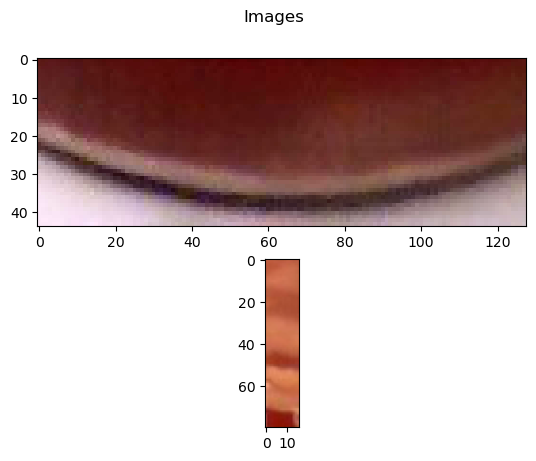

In [8]:
import glob
import os

# Get all .jpg image paths in a folder
folder_path = "../Mark_REP/PythonCode/images/"
image_paths = glob.glob(os.path.join(folder_path, "*.jpg"))

# Sort image paths based on their names (assuming they are named with ascending timestamps)
image_paths.sort()

# Set corresponding timestamps for each image
timestamps = list(range(len(image_paths)))  # Using indices as timestamps, you can replace them with actual timestamps if available

fig, axs = plt.subplots(2)
fig.suptitle('Images')

data = []
for image_path, timestamp in zip(image_paths, timestamps):
      
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize the image
    image = image[224:480, 244:500] # 256 x 256
    
    # sediment
    sediment_image = get_sediment_image(image)
    sediment_image = normalize(sediment_image)
    axs[0].imshow(cv2.cvtColor(sediment_image, cv2.COLOR_BGR2RGB))
    sediment_height= get_height(sediment_image, 1)
    
    # foam
    foam_image = get_foam_image(image)
    foam_image = normalize(foam_image)
    axs[1].imshow(cv2.cvtColor(foam_image, cv2.COLOR_BGR2RGB))
    foam_height= get_height(foam_image, 0)
    
    # beer color
    beer_color = get_beer_color(image)
    
    data.append([timestamp, foam_height, beer_color, sediment_height])

# Convert data to a DataFrame
df = pd.DataFrame(data, columns=["timestamp", "foam_height", "beer_color", "sediment_height"])


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Add fermentation progress to the DataFrame
fermentation_progress = [] # List of fermentation progress values corresponding to each image
for i in range(len(image_paths)):
    fermentation_progress.append(round((100 / (len(image_paths) - 1)) * i, 2))

df["fermentation_progress"] = fermentation_progress
df.head()

,timestamp,foam_height,beer_color,sediment_height,fermentation_progress
0,0,79,"(112.10069444444444, 53.34548611111111, 42.83680555555555)",0,0.00
1,1,79,"(112.015625, 53.390625, 42.89236111111111)",0,33.33
2,2,79,"(106.14583333333333, 49.248263888888886, 40.43402777777778)",0,66.67
3,3,79,"(110.09201388888889, 52.32118055555555, 42.869791666666664)",0,100.00


In [10]:
# Define input and output columns
input_columns = ["foam_height", "beer_color", "sediment_height"]
output_column = "fermentation_progress"

# Normalize the input features using MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(df[input_columns])

# Prepare the output values
y = df[output_column].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Reshape the input data for LSTM (samples, timesteps, features)
timesteps = 1
X_train = X_train.reshape(X_train.shape[0], timesteps, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], timesteps, X_test.shape[1])

ValueError: setting an array element with a sequence.

In [ ]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss="mse", metrics=["mae"])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

In [ ]:
# Evaluate the model on the testing dataset
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test loss: {test_loss}, Test MAE: {test_mae}")

# Visualize the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()